[Sven Kreiss](https://www.svenkreiss.com/), 2019

# Prediction API

Programmatically use OpenPifPaf to run multi-person pose estimation on an image.
The API is for more advanced use cases. Please read {doc}`predict_cli` as well.

In [2]:
%matplotlib inline

import io
import numpy as np
import openpifpaf
import PIL
import requests
import torch

device = torch.device('cpu')
# device = torch.device('cuda')  # if cuda is available

print(openpifpaf.__version__)
print(torch.__version__)

0.11.9
1.7.0


## Load an Example Image

Image credit: "[Learning to surf](https://www.flickr.com/photos/fotologic/6038911779/in/photostream/)" by fotologic which is licensed under [CC-BY-2.0].

[CC-BY-2.0]: https://creativecommons.org/licenses/by/2.0/

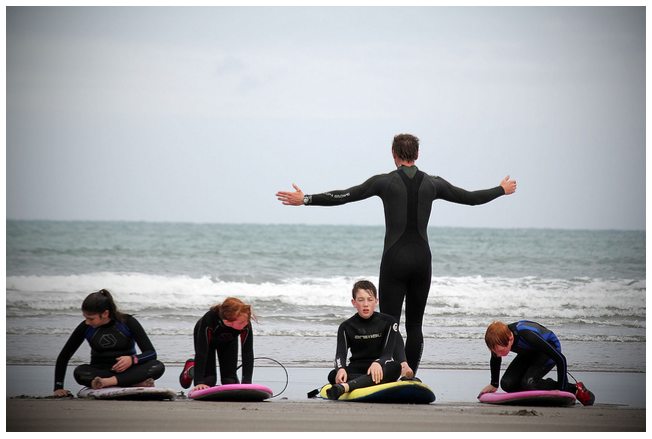

In [3]:
image_response = requests.get('https://raw.githubusercontent.com/vita-epfl/openpifpaf/master/docs/coco/000000081988.jpg')
pil_im = PIL.Image.open('../../datasets/coolingTowersV3/images/train/000005.jpg').convert('RGB')
pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')
im = np.asarray(pil_im)

with openpifpaf.show.image_canvas(im) as ax:
  pass

## Load a Trained Neural Network

In [4]:
net_cpu, _ = openpifpaf.network.factory(checkpoint='shufflenetv2k16w', download_progress=False)
net = net_cpu.to(device)

openpifpaf.decoder.CifSeeds.threshold = 0.5
openpifpaf.decoder.nms.Keypoints.keypoint_threshold = 0.2
openpifpaf.decoder.nms.Keypoints.instance_threshold = 0.2
processor = openpifpaf.decoder.factory_decode(net.head_nets, basenet_stride=net.base_net.stride)

## Preprocessing, Dataset

Specify the image preprocossing. Beyond the default transforms, we also use `CenterPadTight(16)` which adds padding to the image such that both the height and width are multiples of 16 plus 1. With this padding, the feature map covers the entire image. Without it, there would be a gap on the right and bottom of the image that the feature map does not cover.

In [5]:
preprocess = openpifpaf.transforms.Compose([
  openpifpaf.transforms.NormalizeAnnotations(),
  openpifpaf.transforms.CenterPadTight(16),
  openpifpaf.transforms.EVAL_TRANSFORM,
])
data = openpifpaf.datasets.PilImageList([pil_im], preprocess=preprocess)

## Dataloader, Visualizer

In [6]:
loader = torch.utils.data.DataLoader(
  data, batch_size=1, pin_memory=True, 
  collate_fn=openpifpaf.datasets.collate_images_anns_meta)

keypoint_painter = openpifpaf.show.KeypointPainter(color_connections=True, linewidth=6)

## Prediction

/home/martinesguerra/.pyenv/versions/3.7.7/envs/finder_env/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


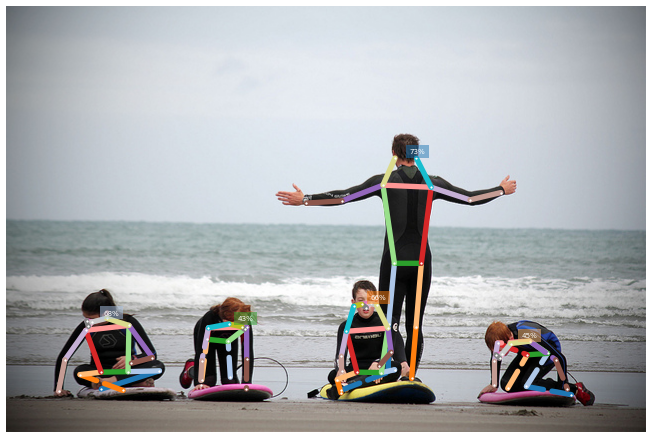

In [7]:
for images_batch, _, __ in loader:
  predictions = processor.batch(net, images_batch, device=device)[0]
  with openpifpaf.show.image_canvas(im) as ax:
    keypoint_painter.annotations(ax, predictions)

## Fields

Below are visualizations of the fields.
When using the API here, the visualization types are individually enabled.
Then, the index for every field to visualize must be specified. In the example below, the fifth CIF (left shoulder) and the fifth CAF (left shoulder to left hip) are activated.

These plots are also accessible from the command line: use `--debug-images` to activate all debug plots and use `--debug-indices cif:5 caf:5` to select which joints and connections to visualize..

In [ ]:
openpifpaf.visualizer.Cif.show_regressions = True
openpifpaf.visualizer.Caf.show_regressions = True
openpifpaf.visualizer.BaseVisualizer.all_indices = [('cif', 5), ('caf', 5)]

for images_batch, _, __ in loader:
  predictions = processor.batch(net, images_batch, device=device)[0]

In [ ]:
# deactivate the previous outputs
openpifpaf.visualizer.Cif.show_regressions = False
openpifpaf.visualizer.Caf.show_regressions = False

From the CIF field, a high resolution accumulation (in the code it's called `CifHr`) is generated.
This is also the basis for the seeds. Both are shown below.

In [ ]:
openpifpaf.visualizer.CifHr.show = True
openpifpaf.visualizer.Seeds.show = True
openpifpaf.visualizer.BaseVisualizer.all_indices = [('cif', 5), ('caf', 5)]

for images_batch, _, __ in loader:
  predictions = processor.batch(net, images_batch, device=device)[0]

In [ ]:
# deactivate previous outputs
openpifpaf.visualizer.CifHr.show = False
openpifpaf.visualizer.Seeds.show = False

Starting from a seed, the poses are constructed. At every joint position, an occupancy map marks whether a previous pose was already constructed here. This reduces the number of poses that are constructed from multiple seeds for the same person. The final occupancy map is below:

In [ ]:
openpifpaf.visualizer.Occupancy.show = True
openpifpaf.visualizer.BaseVisualizer.all_indices = [('occupancy', 5)]

for images_batch, _, __ in loader:
  predictions = processor.batch(net, images_batch, device=device)[0]